(1000, 1000)


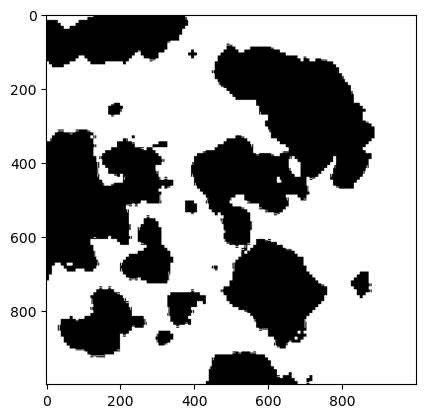

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
from scipy import ndimage as ndi

import napari

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

os.chdir("E:/data_for_seg/z_projection/split")
# Example: List the contents of the current folder
files = os.listdir()
files = [file for file in files if "Simple" in file]
image = cv2.imread(files[0], cv2.IMREAD_GRAYSCALE)
image = np.where(image == 255, 0, 255)
image = image.astype(np.uint8)
print(image.shape)
plt.imshow(image, cmap="gray")
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

viewer = napari.Viewer()
image_layer = viewer.add_image(image)
labels_layer = viewer.add_labels(labels)
labels_as_image_layer = viewer.add_image(
    labels, name='labels as image'
)

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
from scipy import ndimage as ndi

import napari

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

spacing = np.array([0.26, 0.26])

viewer = napari.view_image(
    image,
    scale=spacing,
    ndisplay=2,
)

In [4]:
from skimage import filters

edges = filters.scharr(image)
viewer.add_image(
    edges,
    scale=spacing,
    blending='additive',
    colormap='magenta',
)

<Image layer 'edges' at 0x2720977ca60>

In [5]:
denoised = ndi.median_filter(image, size=3)
li_thresholded = denoised > filters.threshold_li(denoised)
viewer.add_image(
    li_thresholded,
    scale=spacing,
    opacity=0.3,
)

<Image layer 'li_thresholded' at 0x2720977ca30>

In [67]:
from scipy import ndimage

li_thresholded = np.array([[not cell for cell in row] for row in li_thresholded])

li_thresholded = ndimage.binary_fill_holes(li_thresholded).astype(int)

viewer.add_image(
    li_thresholded,
    name='fill_holes',
    scale=spacing,
    opacity=0.3,
)


<Image layer 'fill_holes' at 0x1ef912c3150>

In [68]:
from skimage import morphology

width = 10

remove_holes = morphology.remove_small_holes(
    li_thresholded, width ** 3
)

width = 10

remove_objects = morphology.remove_small_objects(
    remove_holes, width ** 3
)

viewer.add_image(
    remove_objects,
    name='cleaned',
    scale=spacing,
    opacity=0.3,
)

viewer.layers['li_thresholded'].visible = False

C:\Users\Laurent\AppData\Local\Temp\ipykernel_10804\4136182613.py:5: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  remove_holes = morphology.remove_small_holes(


In [69]:
from skimage import measure

labels = measure.label(remove_objects)

viewer.add_labels(
    labels,
    scale=spacing,
    opacity=0.5,
)

viewer.layers['cleaned'].visible = False

In [143]:
"""
transformed = ndi.distance_transform_edt(remove_objects, sampling=spacing)

maxima = morphology.local_maxima(transformed)
viewer.add_points(
    np.transpose(np.nonzero(maxima)),
    name='bad points',
    scale=spacing,
    size=3,
    n_dimensional=True,  # points have 3D "extent"
)
"""

<Points layer 'bad points' at 0x2331d3a52a0>

In [153]:
"""
from skimage import segmentation

marker_locations = maxima

markers = np.zeros(image.shape, dtype=np.uint32)
marker_indices = tuple(np.round(marker_locations).astype(int).T)
markers[marker_indices] = np.arange(len(marker_locations)) + 1
markers_big = morphology.dilation(markers, morphology.disk(radius=5))

segmented = segmentation.watershed(
    edges,
    markers_big,
    mask=remove_objects,
)

viewer.add_labels(
    segmented,
    scale=spacing,
)

viewer.layers['labels'].visible = False
"""

"\nfrom skimage import segmentation\n\nmarker_locations = maxima\n\nmarkers = np.zeros(image.shape, dtype=np.uint32)\nmarker_indices = tuple(np.round(marker_locations).astype(int).T)\nmarkers[marker_indices] = np.arange(len(marker_locations)) + 1\nmarkers_big = morphology.dilation(markers, morphology.disk(radius=5))\n\nsegmented = segmentation.watershed(\n    edges,\n    markers_big,\n    mask=remove_objects,\n)\n\nviewer.add_labels(\n    segmented,\n    scale=spacing,\n)\n\nviewer.layers['labels'].visible = False\n"

In [154]:
regionprops = measure.regionprops(labels, intensity_image=image)

supported = [] 
unsupported = []

for prop in regionprops[0]:
    try:
        regionprops[0][prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print("Supported properties:")
print("  " + "\n  ".join(supported))
print()
print("Unsupported properties:")
print("  " + "\n  ".join(unsupported))

Supported properties:
  area
  area_bbox
  area_convex
  area_filled
  axis_major_length
  axis_minor_length
  bbox
  centroid
  centroid_local
  centroid_weighted
  centroid_weighted_local
  coords
  eccentricity
  equivalent_diameter_area
  euler_number
  extent
  feret_diameter_max
  image
  image_convex
  image_filled
  image_intensity
  inertia_tensor
  inertia_tensor_eigvals
  intensity_max
  intensity_mean
  intensity_min
  label
  moments
  moments_central
  moments_hu
  moments_normalized
  moments_weighted
  moments_weighted_central
  moments_weighted_hu
  moments_weighted_normalized
  orientation
  perimeter
  perimeter_crofton
  slice
  solidity

Unsupported properties:
  


In [77]:
import pandas as pd

info_table = pd.DataFrame(
    measure.regionprops_table(
        labels,
        intensity_image=image,
        properties=['label', 'slice', 'area', 'mean_intensity', 'solidity'],
    )
)

In [79]:
info_table.head()
#print(info_table["slice"])

,label,slice,area,mean_intensity,solidity
0,1,"(slice(313, 991, None), slice(0, 700, None))",290417.0,16.092557,0.883546


# PIPELINE OF FEATURE EXTRACTION

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from skimage import exposure
from scipy import ndimage
from cellpose import models
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import filters
from skimage import morphology
from skimage import measure
from matplotlib import colors
from importlib import reload
import utility
reload(utility)
from utility import get_hard_disk_path, compute_big_cell_labels, compute_small_cell_labels, calculate_closest_boundary_distances

initial_path = r"E:\data_for_seg_without_dead\\"
all_labels = ["keep2", "reseed1", "split", "empty", "keep0", "keep1", "reseed0"]
labels_big_cell = ["keep2", "reseed1", "split"]
labels_small_cell = ["empty", "keep0", "keep1", "reseed0"]
properties_list = ['area', 'mean_intensity', 'solidity', 'convex_area', 'equivalent_diameter', 'perimeter', 'extent', 'max_intensity', 'min_intensity', 'eccentricity']
output_csv = initial_path + "statistics_features_IP.csv"  # Adjust the output file name

def compute_feature_statistics(data, output_csv, properties_list):
    statistics = {}

    other_features = {
        "image_name": data["image_name"].iloc[0],  # Assuming 'image_name' is the same for all rows in data
        "label": data["label"].iloc[0],  # Assuming 'label' is the same for all rows in data
        "count": data["sample"].max(),
        "occupancy": data["occupancy"],
        #"density": data["density"]
    }
    statistics.update(other_features)

    for column_name in properties_list:
        if column_name in data.columns:
            column = data[column_name]

            # Calculate statistics for the current column
            mean_value = column.mean()
            sd_value = column.std()
            min_value = column.min()
            max_value = column.max()

            # Add the statistics to the row dictionary
            statistics.update({
                f"{column_name}_Mean": mean_value,
                f"{column_name}_StdDev": sd_value,
                f"{column_name}_Min": min_value,
                f"{column_name}_Max": max_value,
            })

    # Create a DataFrame from the dictionary
    statistics_df = pd.DataFrame(statistics, index=[0])

    # Save the DataFrame to the output CSV file
    statistics_df.to_csv(output_csv, mode='a', header=not os.path.isfile(output_csv), index=False)

def compute_occupancy(labels, image):
    """
    Compute the occupancy of cells in the image.
    
    Parameters:
    - labels: labeled image
    - image: original grayscale image
    
    Returns:
    - occupancy: ratio of cell area to total image area
    """
    cell_area = np.sum(labels > 0)  # Total number of pixels occupied by cells
    image_area = image.size         # Total number of pixels in the image
    return cell_area / image_area

if os.path.exists(output_csv):
    os.remove(output_csv)

if not os.path.exists(initial_path + "labeled/"):
    os.makedirs(initial_path + "labeled/")

for label in all_labels:
    label_path = os.path.join(initial_path + "labeled", label)
    if not os.path.exists(label_path):
        os.mkdir(label_path)
    if not os.path.exists(os.path.join(label_path, "IP_pipeline")):
        os.mkdir(os.path.join(label_path, "IP_pipeline"))
    os.chdir(os.path.join(initial_path + "z_projection", label))
    files = [file for file in os.listdir() if "Simple" not in file and "filled" not in file]
    print(files)
    for file in files:
        if "Simple" or "filled" not in file:
            image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            if label in labels_big_cell:
                print(file)
                labels = compute_big_cell_labels(image)
            elif label in labels_small_cell:
                labels = compute_small_cell_labels(image)
            # Generate a colormap for labels
            label_cmap = colors.ListedColormap(np.random.rand(labels.max() + 1, 3))

            # Create a colored label image
            colored_label_image = label_cmap(labels)

            # Convert to uint8 format (0-255)
            colored_label_image = (colored_label_image * 255).astype(np.uint8)

            output_path = os.path.join(label_path, "IP_pipeline", file)
            if not os.path.exists(output_path):
                cv2.imwrite(output_path, cv2.cvtColor(colored_label_image, cv2.COLOR_RGBA2BGRA))

            info_table = pd.DataFrame(
                measure.regionprops_table(
                    labels,
                    intensity_image=image,
                    properties=['label', 'area', 'mean_intensity', 'solidity', 'convex_area', 'equivalent_diameter', 'perimeter', 'extent', 'max_intensity', 'min_intensity', 'eccentricity'],
                )
            )

            occupancy = compute_occupancy(labels, image)
            #density = calculate_closest_boundary_distances(labels)
            #info_table['density'] = density
            info_table['occupancy'] = occupancy  # Add the occupancy to the statistics
            info_table = info_table.rename(columns={"label": "sample"})
            info_table['label'] = label
            info_table['image_name'] = file

            compute_feature_statistics(info_table, output_csv, properties_list)

['s05_no_stack.jpg', 's06_no_stack.jpg', 's07_no_stack.jpg', 's08_no_stack.jpg', 's05.jpg', 's06.jpg', 's07.jpg', 's08.jpg', 's03_no_stack.jpg', 's04_no_stack.jpg', 's12.jpg', 's13.jpg', 's14.jpg', 's12_no_stack.jpg', 's13_no_stack.jpg', 's14_no_stack.jpg', 's09_no_stack.jpg', 's09.jpg', 's19.jpg']
s05_no_stack.jpg
s06_no_stack.jpg
s07_no_stack.jpg
s08_no_stack.jpg
s05.jpg
s06.jpg
s07.jpg
s08.jpg
s03_no_stack.jpg
s04_no_stack.jpg
s12.jpg
s13.jpg
s14.jpg
s12_no_stack.jpg
s13_no_stack.jpg
s14_no_stack.jpg
s09_no_stack.jpg
s09.jpg
s19.jpg
['s13.jpg', 's14.jpg', 's15.jpg', 's17.jpg', 's19.jpg', 's20.jpg', 's21.jpg', 's22.jpg', 's23.jpg', 's24.jpg']
s13.jpg
s14.jpg
s15.jpg
s17.jpg
s19.jpg
s20.jpg
s21.jpg
s22.jpg
s23.jpg
s24.jpg
['s03.jpg', 's04.jpg', 's05.jpg', 's08.jpg', 's07.jpg', 's06.jpg', 's17.jpg', 's16.jpg', 's12.jpg', 's13.jpg', 's18.jpg', 's19.jpg', 's02_no_stack.jpg', 's06_no_stack.jpg', 's09.jpg', 's03_no_stack.jpg', 's04 (2).jpg', 's05 (2).jpg', 's06 (2).jpg', 's08 (2).jpg', 's1

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from scipy.spatial.distance import cdist
from skimage import exposure
from scipy import ndimage
from cellpose import models
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import filters
from skimage import morphology
from skimage import measure
from matplotlib import colors
from importlib import reload
import utility
reload(utility)
from utility import get_hard_disk_path, compute_big_cell_labels, compute_small_cell_labels, calculate_closest_boundary_distances

initial_path = r"E:\data_for_seg_without_dead\\"
all_labels = ["keep2", "reseed1", "split", "empty", "keep0", "keep1", "reseed0"]
labels_big_cell = ["keep2", "reseed1", "split"]
labels_small_cell = ["empty", "keep0", "keep1", "reseed0"]
properties_list = ['area', 'mean_intensity', 'solidity', 'convex_area', 'equivalent_diameter', 'perimeter', 'extent', 'max_intensity', 'min_intensity', 'eccentricity']
output_csv = initial_path + "statistics_features_ilastik.csv"  # Adjust the output file name

# --------------------
# ALL FUNCTIONS
# --------------------

def compute_feature_statistics(data, output_csv, properties_list):
    statistics = {}

    other_features = {
        "image_name": data["image_name"].iloc[0],  # Assuming 'image_name' is the same for all rows in data
        "label": data["label"].iloc[0],  # Assuming 'label' is the same for all rows in data
        "count": data["sample"].max(),
        "occupancy": data["occupancy"],
        #"density": data["density"]
    }
    statistics.update(other_features)

    for column_name in properties_list:
        if column_name in data.columns:
            column = data[column_name]

            # Calculate statistics for the current column
            mean_value = column.mean()
            sd_value = column.std()
            min_value = column.min()
            max_value = column.max()

            # Add the statistics to the row dictionary
            statistics.update({
                f"{column_name}_Mean": mean_value,
                f"{column_name}_StdDev": sd_value,
                f"{column_name}_Min": min_value,
                f"{column_name}_Max": max_value,
            })

    # Create a DataFrame from the dictionary
    statistics_df = pd.DataFrame(statistics, index=[0])

    # Save the DataFrame to the output CSV file
    statistics_df.to_csv(output_csv, mode='a', header=not os.path.isfile(output_csv), index=False)

def compute_occupancy(labels, image):
    """
    Compute the occupancy of cells in the image.
    
    Parameters:
    - labels: labeled image
    - image: original grayscale image
    
    Returns:
    - occupancy: ratio of cell area to total image area
    """
    cell_area = np.sum(labels > 0)  # Total number of pixels occupied by cells
    image_area = image.size         # Total number of pixels in the image
    return cell_area / image_area

def extract_features(labels, output_path, image_path):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    print(image_path)
    # Generate a colormap for labels
    label_cmap = colors.ListedColormap(np.random.rand(labels.max() + 1, 3))

    # Create a colored label image
    colored_label_image = label_cmap(labels)

    # Convert to uint8 format (0-255)
    colored_label_image = (colored_label_image * 255).astype(np.uint8)

    if not os.path.exists(output_path):
        cv2.imwrite(output_path, cv2.cvtColor(colored_label_image, cv2.COLOR_RGBA2BGRA))

    info_table = pd.DataFrame(
        measure.regionprops_table(
            labels,
            intensity_image=image,
            properties=['label', 'area', 'mean_intensity', 'solidity', 'convex_area', 'equivalent_diameter', 'perimeter', 'extent', 'max_intensity', 'min_intensity', 'eccentricity'],
        )
    )

    occupancy = compute_occupancy(labels, image)
    #density = calculate_closest_boundary_distances(labels)
    #info_table['density'] = density
    info_table['occupancy'] = occupancy  # Add the occupancy to the statistics
    info_table = info_table.rename(columns={"label": "sample"})
    info_table['label'] = label
    info_table['image_name'] = os.path.basename(image_path)

    compute_feature_statistics(info_table, output_csv, properties_list)

# --------------------
# MAIN
# --------------------

if os.path.exists(output_csv):
    os.remove(output_csv)

if not os.path.exists(initial_path + "labeled/"):
    os.makedirs(initial_path + "labeled/")
    

for label in all_labels:
    label_path = os.path.join(initial_path + "labeled", label)
    if not os.path.exists(label_path):
        os.mkdir(label_path)
    os.chdir(os.path.join(initial_path + "z_projection", label))
    if not os.path.exists(os.path.join(label_path, "Ilastik_pipeline")):
        os.mkdir(os.path.join(label_path, "Ilastik_pipeline"))
    files = os.listdir()
    if not os.path.exists("filled_cleaned"):
        for file in files:
            if "Simple" not in file:
                image_path = file
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                labels = compute_small_cell_labels(image)
                output_path = os.path.join(label_path, "Ilastik_pipeline", file)
                extract_features(labels, output_path, image_path)
    elif os.path.exists(os.path.join(initial_path, "z_projection", label, "filled_cleaned")):
        # Define the directory for filled_cleaned files and original_files
        filled_cleaned_dir = os.path.join(initial_path, "z_projection", label, "filled_cleaned")
        original_files_dir = os.path.join(filled_cleaned_dir, "original_files")

        # Get a list of files in filled_cleaned directory
        filled_cleaned_files = os.listdir(filled_cleaned_dir)

        for file in filled_cleaned_files:
            if "labeled_filled" in file:

                # Read the labels file using the full path
                labels_path = os.path.join(filled_cleaned_dir, file)
                labels = cv2.imread(labels_path, cv2.IMREAD_UNCHANGED)

                # Check if the labels were read successfully
                if labels is None:
                    print(f"Failed to read labels from {labels_path}")
                    continue

                labels = labels.astype(int)

                # Create the output path for labeled_cleaned files
                output_path = os.path.join(label_path, "Ilastik_pipeline", file)

                image_path = os.path.join(original_files_dir, file[15:-24] + ".jpg")

                # Check if the image was read successfully
                if image is None:
                    print(f"Failed to read image from {image_path}")
                    continue

                # Now you can extract features with the correct image and labels
                extract_features(labels, output_path, image_path)


Successfully loaded data from E:/data_for_seg/
E:/data_for_seg/z_projection\dead\filled_cleaned\original_files\s09.jpg
E:/data_for_seg/z_projection\dead\filled_cleaned\original_files\s11_no_stack.jpg
E:/data_for_seg/z_projection\dead\filled_cleaned\original_files\s12_no_stack.jpg
E:/data_for_seg/z_projection\dead\filled_cleaned\original_files\s12.jpg
E:/data_for_seg/z_projection\dead\filled_cleaned\original_files\s13_no_stack.jpg
E:/data_for_seg/z_projection\dead\filled_cleaned\original_files\s13.jpg
E:/data_for_seg/z_projection\dead\filled_cleaned\original_files\s01.jpg
E:/data_for_seg/z_projection\dead\filled_cleaned\original_files\s02_no_stack.jpg
E:/data_for_seg/z_projection\dead\filled_cleaned\original_files\s02.jpg
E:/data_for_seg/z_projection\dead\filled_cleaned\original_files\s03_no_stack.jpg
E:/data_for_seg/z_projection\dead\filled_cleaned\original_files\s03.jpg
E:/data_for_seg/z_projection\dead\filled_cleaned\original_files\s04_no_stack.jpg
E:/data_for_seg/z_projection\dead\f

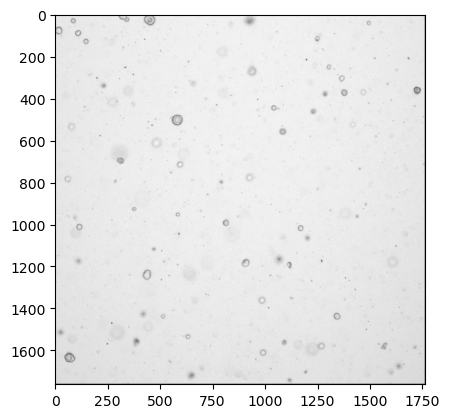

100%|██████████| 3.54k/3.54k [00:00<00:00, 3.63MB/s]


In [23]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from skimage import exposure
from scipy import ndimage
from cellpose import models
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import filters
from skimage import morphology
from skimage import measure
from matplotlib import colors
from importlib import reload
import utility
reload(utility)
from utility import get_hard_disk_path, compute_big_cell_labels, compute_small_cell_labels, calculate_closest_boundary_distances

initial_path = "D:/RawDataLaurent/NT_top&combo_bot-Day1/"
properties_list = ['area', 'mean_intensity', 'solidity', 'convex_area', 'equivalent_diameter', 'perimeter', 'extent', 'max_intensity', 'min_intensity', 'eccentricity']
output_csv = initial_path + "statistics_features_IP.csv"  # Adjust the output file name

def compute_feature_statistics(data, output_csv, properties_list):
    statistics = {}

    other_features = {
        "image_name": data["image_name"].iloc[0],  # Assuming 'image_name' is the same for all rows in data
        "label": data["label"].iloc[0],  # Assuming 'label' is the same for all rows in data
        "count": data["sample"].max(),
        "occupancy": data["occupancy"],
        #"density": data["density"]
    }
    statistics.update(other_features)

    for column_name in properties_list:
        if column_name in data.columns:
            column = data[column_name]

            # Calculate statistics for the current column
            mean_value = column.mean()
            sd_value = column.std()
            min_value = column.min()
            max_value = column.max()

            # Add the statistics to the row dictionary
            statistics.update({
                f"{column_name}_Mean": mean_value,
                f"{column_name}_StdDev": sd_value,
                f"{column_name}_Min": min_value,
                f"{column_name}_Max": max_value,
            })

    # Create a DataFrame from the dictionary
    statistics_df = pd.DataFrame(statistics, index=[0])

    # Save the DataFrame to the output CSV file
    statistics_df.to_csv(output_csv, mode='a', header=not os.path.isfile(output_csv), index=False)

def compute_occupancy(labels, image):
    """
    Compute the occupancy of cells in the image.
    
    Parameters:
    - labels: labeled image
    - image: original grayscale image
    
    Returns:
    - occupancy: ratio of cell area to total image area
    """
    cell_area = np.sum(labels > 0)  # Total number of pixels occupied by cells
    image_area = image.size         # Total number of pixels in the image
    return cell_area / image_area

if os.path.exists(output_csv):
    os.remove(output_csv)

if not os.path.exists(initial_path + "labeled/"):
    os.makedirs(initial_path + "labeled/")

label_path = os.path.join(initial_path + "labeled")
if not os.path.exists(label_path):
    os.mkdir(label_path)
if not os.path.exists(os.path.join(label_path, "IP_pipeline")):
    os.mkdir(os.path.join(label_path, "IP_pipeline"))
file = os.path.join(initial_path, "NT_top&combo_bot-Day1_s005z4.jpg")
image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap="gray")
plt.show()
labels = compute_small_cell_labels(image)

# Generate a colormap for labels
label_cmap = colors.ListedColormap(np.random.rand(labels.max() + 1, 3))

# Create a colored label image
colored_label_image = label_cmap(labels)

# Convert to uint8 format (0-255)
colored_label_image = (colored_label_image * 255).astype(np.uint8)

output_path = os.path.join(label_path, "IP_pipeline", "NT_top&combo_bot-Day1_s005z4.jpg")
cv2.imwrite(output_path, cv2.cvtColor(colored_label_image, cv2.COLOR_RGBA2BGRA))

info_table = pd.DataFrame(
    measure.regionprops_table(
        labels,
        intensity_image=image,
        properties=['label', 'area', 'mean_intensity', 'solidity', 'convex_area', 'equivalent_diameter', 'perimeter', 'extent', 'max_intensity', 'min_intensity', 'eccentricity'],
    )
)

occupancy = compute_occupancy(labels, image)
#density = calculate_closest_boundary_distances(labels)
#info_table['density'] = density
info_table['occupancy'] = occupancy  # Add the occupancy to the statistics
info_table = info_table.rename(columns={"label": "sample"})
info_table['label'] = "None"
info_table['image_name'] = file

compute_feature_statistics(info_table, output_csv, properties_list)